In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

import datetime

Constants

In [22]:
print(tf.__version__)
INPUT_SHAPE = (224, 224, 3)

2.9.2


# Assets

In [5]:
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [6]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [7]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Image data loading

In [8]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

True


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete8NID1Q/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete8NID1Q/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
class_names = ds_info.features['label'].names
print(len(class_names))

101


# Image data exploration

In [11]:
train_one_sample = train_data.take(1)
print(train_one_sample)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [12]:
for image, label in train_one_sample:
    print(f"""Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")

Image shape: (512, 384, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 74
    Class name (str form): peking_duck


(-0.5, 383.5, 511.5, -0.5)

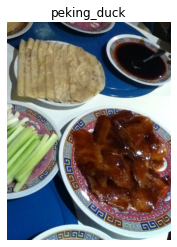

In [13]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

# Image data preprocessing

In [14]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts images to dtype float32, and reshapes images to
    (img_shape, img_shape, channels)
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    
    return tf.cast(image, tf.float32), label

## Callbacks

In [15]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [16]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[152 129  77]
  [160 137  85]
  [160 137  85]
  ...
  [ 26  21  18]
  [ 24  19  16]
  [ 21  16  13]]

 [[156 133  81]
  [158 135  83]
  [155 132  80]
  ...
  [ 25  20  17]
  [ 23  18  15]
  [ 22  17  14]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[156.05103  133.05103   81.05102 ]
  [156.13776  133.13776   81.13776 ]
  [146.31122  123.311226  71.311226]
  ...
  [ 22.454105  17.454105  13.668401]
  [ 25.306135  20.306135  17.306135]
  [ 22.25511   17.25511   14.25511 ]]

 [[159.82652  136.82652   82.82653 ]
  [149.79591  126.79591   72.79591 ]
  [132.69388  109.69388   57.26531 ]
  ...
  [ 24.183672  19.183672  15.397966]
  [ 22.21425   17.21425   14.214251]
  [ 18.83164   14.83164   11.83164 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

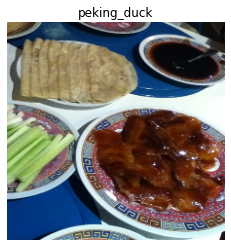

In [17]:
plt.imshow(preprocessed_img / 255.)
plt.title(class_names[label])
plt.axis(False)

In [18]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# EfficientNetB0 Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

history_food_classes_fine_tune = model.fit(train_data,
                                                  epochs=100,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data=test_data,
                                                  validation_steps=int(0.15 * len(test_data)),
                                                  callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_classes_all_data_fine_tuning"),
                                                             model_checkpoint,
                                                             early_stopping,
                                                             reduce_lr])

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
input_3 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "float32">
normalization_2 True float32 <Policy "float32">
tf.math.truediv_2 True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "float32">
stem_conv True float32 <Policy "float32">
stem_bn True float32 <Policy "float32">
stem_activation True float32 <Policy "float32">
block1a_dwconv True float32 <Policy "float32">
block1a_bn True float32 <Policy "float32">
block1a_activation True float32 <Policy "float32">
block1a_se_squeeze True float32 <Policy "float32">
block1a_se_reshape True float32 <Policy "float32">
block1a_se_reduce True float32 <Policy "float32">
block1a_se_expand True float32 <Policy "float32">
block1a_se_excite True float32 <Policy "float32">
block1a_project_conv True 

# Evaluating model

In [ ]:
results_model = model.evaluate(test_data)
print(results_model)

# Saving and loading model

In [ ]:
save_dir = "efficientnetb0_model"
model.save(save_dir)

loaded_model = tf.keras.models.load_model(save_dir)

In [ ]:
loaded_model.load_weights(checkpoint_path)